## Hi there!

This notebook includes native implementation of REINFORCE algorithm. We compute gradients on our own, implement gradient descent and set the policy function. Used methods and functions differ from those, that we described in the report. This notebook is created to see that happens under the hood of REINFORCE. 

The code is based on: https://medium.com/samkirkiles/reinforce-policy-gradients-from-scratch-in-numpy-6a09ae0dfe12


In [164]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import copy 

Set the hyperparameters for REINFORCE. Choose wisely:)

In [165]:
#Hyperparameters
NUM_EPISODES = 10000 # maximum number of episode
LEARNING_RATE = 0.001 # learning rate
GAMMA = 0.99 # discount rate for discounted value function

Ctrate the environment and investigate it

In [166]:
# Create gym and seed numpy
env = gym.make('LunarLander-v2') # LunarLander-v2  # CartPole-v0
nA = env.action_space.n
np.random.seed(1)

In [167]:
print("Chosen environment has {}-shape states".format(env.observation_space.shape[0]))
print("There is {} possible actions to choose".format(env.action_space.n))

Chosen environment has 8-shape states
There is 4 possible actions to choose


In [168]:
print("The initail state is {}". format(env.reset()))

The initail state is [-0.00331755  1.4123735  -0.33606035  0.06460485  0.00385111  0.07612275
  0.          0.        ]


Now we will intitialize the policy function - Softmax function. This function was chosen because it is easy to find the derivative analiticaly. If you are interested how to find derivative, there is a step-by-step explanation: https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/

In [169]:
# Our policy that maps state to action parameterized by w
def policy(state,w):
    z = state.dot(w)
    exp = np.exp(z)
    return exp/np.sum(exp)

# Vectorized softmax Jacobian
def softmax_grad(softmax):
    s = softmax.reshape(-1,1)
    return np.diagflat(s) - np.dot(s, s.T)

Before starting episode we need to initialize parameters $\theta$.

In [170]:
# Init weight
w = np.random.rand(env.observation_space.shape[0], env.action_space.n)

Now we run one step in the environment and see what are the variables.

In [171]:
state = env.reset()[None,:] # reshape state
probs = policy(state,w)  # find probabilities of do the action from policy 
action = np.random.choice(nA,p=probs[0])  # sample the action 
next_state,reward,done,_ = env.step(action)  # make the action in the environment and get the feedback
next_state = next_state[None,:]  # reshape state

# Compute gradient 
dsoftmax = softmax_grad(probs)[action,:]
dlog = dsoftmax / probs[0,action]
grad = state.T.dot(dlog[None,:])

This is probabilities that was generated by policy

In [172]:
probs

array([[0.21277892, 0.21830162, 0.23418009, 0.33473938]])

The agent chooses this action

In [173]:
action

3

The environment put us in a new state

In [174]:
state

array([[ 0.00414305,  1.4128655 ,  0.41962332,  0.08645978, -0.0047939 ,
        -0.09505092,  0.        ,  0.        ]], dtype=float32)

And gave reward to agent (or not)

In [175]:
reward

-1.4018014744198968

And we computed such gradient (Jacobian)

In [176]:
grad

array([[-8.81553100e-04, -9.04433885e-04, -9.70219146e-04,
         2.75620613e-03],
       [-3.00628000e-01, -3.08430825e-01, -3.30864972e-01,
         9.39923797e-01],
       [-8.92869961e-02, -9.16044476e-02, -9.82674250e-02,
         2.79158869e-01],
       [-1.83968183e-02, -1.88743093e-02, -2.02471585e-02,
         5.75182860e-02],
       [ 1.02004029e-03,  1.04651552e-03,  1.12263529e-03,
        -3.18919109e-03],
       [ 2.02248329e-02,  2.07497701e-02,  2.22590337e-02,
        -6.32336367e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

### Now it is time to run the learning! 

We initialize all the variables again. Note:

1. The process ends whan: 

    (a) we reach the maximum of episodes
    
    (b) mean of the last 100 episode rewards is more than 200 (you can change this parameter accoding to your preferences)
    
2. At first we run all the steps of the episode, remember the results. When the episode ends, we recompute the weights.

By default maximum steps is set. You can change it if you want

In [177]:
env._max_episode_steps

1000

In [178]:
# Init weight
w = np.random.rand(env.observation_space.shape[0], env.action_space.n)

# Keep rewards for final plot of convergence
episode_rewards = []

# Count the steps that was made in all the episodes
count_steps = 0
for e in range(NUM_EPISODES):
    state = env.reset()[None,:]
    
    # For each episode we need to remember the gradients and rewards that was found on each step 
    grads = []
    rewards = []
    
    # Keep track of game score to print
    score = 0
    while True:
        count_steps += 1
        
        # Uncomment to see your model train in real time (slower)
        #env.render()
        
        # Make the step as we did earlier
        probs = policy(state,w)
        action = np.random.choice(nA,p=probs[0])
        next_state,reward,done,_ = env.step(action)
        next_state = next_state[None,:]

        dsoftmax = softmax_grad(probs)[action,:]
        dlog = dsoftmax / probs[0,action]
        grad = state.T.dot(dlog[None,:])

        # Remember the results
        grads.append(grad)
        rewards.append(reward)
        score+=reward

        # Dont forget to update your old state to the new state
        state = next_state
        if done:
            break
            
    # Weight update after the episode
    for i in range(len(grads)):

        # Loop through everything that happend in the episode and update towards the log policy gradient times **FUTURE** reward
        w += LEARNING_RATE * grads[i] * sum([ r * (GAMMA ** r) for t,r in enumerate(rewards[i:])])

    # Append for logging and print
    episode_rewards.append(score)
    # check if the process converged
    if np.mean(episode_rewards[-100:]) >= 195:
        break
    print("EP: " + str(e) + " Score: " + str(score)) 

EP: 0 Score: -315.4575427397964
EP: 1 Score: -309.8138911109786
EP: 2 Score: -197.27748388020015
EP: 3 Score: -99.44042025205401
EP: 4 Score: -131.43910583729289
EP: 5 Score: -142.86552237903743
EP: 6 Score: -576.4945879480437
EP: 7 Score: -216.60283760428652
EP: 8 Score: -290.1496407598624
EP: 9 Score: -141.59784972999432
EP: 10 Score: -483.37224124323353
EP: 11 Score: -97.38195225927575
EP: 12 Score: -177.09175857228163
EP: 13 Score: -134.11856318671104
EP: 14 Score: -165.25620330703654
EP: 15 Score: -137.19141630438457
EP: 16 Score: -122.62855641408328
EP: 17 Score: -118.38418497207903
EP: 18 Score: -138.41141844773514
EP: 19 Score: -142.59399147017865
EP: 20 Score: -134.3987806475692
EP: 21 Score: -118.5758768925364
EP: 22 Score: -135.26079412160144
EP: 23 Score: -124.94975521398126
EP: 24 Score: -27.426013754695887
EP: 25 Score: -176.4102714649046
EP: 26 Score: -156.9717066840425
EP: 27 Score: -133.2093935267055
EP: 28 Score: -101.03433000806413
EP: 29 Score: -105.27989151329166
E

EP: 241 Score: -128.1241775485722
EP: 242 Score: -182.44864530340368
EP: 243 Score: -155.5574499665665
EP: 244 Score: -139.50619181100407
EP: 245 Score: -137.32453789878474
EP: 246 Score: -119.05527810295476
EP: 247 Score: -160.4133526344433
EP: 248 Score: -123.6172224306741
EP: 249 Score: -147.1661350943206
EP: 250 Score: -137.27332896689296
EP: 251 Score: -68.08189741278952
EP: 252 Score: -121.55116018697706
EP: 253 Score: -141.4431180544678
EP: 254 Score: -176.73823889027338
EP: 255 Score: -133.07802082340515
EP: 256 Score: -151.82431087938122
EP: 257 Score: -166.64530002654328
EP: 258 Score: -223.5005834525519
EP: 259 Score: -121.24317901566656
EP: 260 Score: -115.70381482939868
EP: 261 Score: -110.95246465110193
EP: 262 Score: -142.49163418746397
EP: 263 Score: -121.22779146324069
EP: 264 Score: 26.216184906018796
EP: 265 Score: -134.58966504458422
EP: 266 Score: -125.07880858165689
EP: 267 Score: -34.362558804011215
EP: 268 Score: -135.2769892711985
EP: 269 Score: -162.3240704654

EP: 483 Score: 3.5962262928597823
EP: 484 Score: -127.63848131751669
EP: 485 Score: -154.58758165787162
EP: 486 Score: -147.2070957269753
EP: 487 Score: -114.54790651138052
EP: 488 Score: -120.11231185814967
EP: 489 Score: -98.49038678378503
EP: 490 Score: -132.45912998733516
EP: 491 Score: -412.74749010882147
EP: 492 Score: -141.0069132274475
EP: 493 Score: -140.36957962227729
EP: 494 Score: -154.20130218234738
EP: 495 Score: -144.9178717579749
EP: 496 Score: -147.93445699436114
EP: 497 Score: -122.90903084096774
EP: 498 Score: -171.64138987531965
EP: 499 Score: -159.48644043833713
EP: 500 Score: -130.60139291625433
EP: 501 Score: -103.80717520062004
EP: 502 Score: -261.7430186756609
EP: 503 Score: 35.571195019796505
EP: 504 Score: -182.82987854726085
EP: 505 Score: -393.35863585707096
EP: 506 Score: -192.2703463290847
EP: 507 Score: -125.07553681838195
EP: 508 Score: -142.90251599252804
EP: 509 Score: -155.95293214376903
EP: 510 Score: -156.7002623506203
EP: 511 Score: -155.746211346

EP: 722 Score: -147.76005004501877
EP: 723 Score: -127.53209839750528
EP: 724 Score: -99.12505673457511
EP: 725 Score: -136.231179344795
EP: 726 Score: -118.84751636191845
EP: 727 Score: -145.81612427084497
EP: 728 Score: -83.82304123923572
EP: 729 Score: -123.41316846538737
EP: 730 Score: -153.43961407344338
EP: 731 Score: -183.49198899945085
EP: 732 Score: -19.665478385760892
EP: 733 Score: -140.3156205783547
EP: 734 Score: -177.02174673412375
EP: 735 Score: -134.41516051848467
EP: 736 Score: -141.7758015687515
EP: 737 Score: -111.1167328588063
EP: 738 Score: -53.44228361508806
EP: 739 Score: -95.95585622970322
EP: 740 Score: -132.9740398984656
EP: 741 Score: -135.8142274498497
EP: 742 Score: -129.28279875456215
EP: 743 Score: -123.4124551899709
EP: 744 Score: -147.8622406148026
EP: 745 Score: -141.33559465924392
EP: 746 Score: -101.7432626251769
EP: 747 Score: -159.53424990243778
EP: 748 Score: -137.68439736888203
EP: 749 Score: -148.9999982540322
EP: 750 Score: -299.54584618943375


EP: 974 Score: -149.5533842313432
EP: 975 Score: -97.49685575806612
EP: 976 Score: -147.31699620814135
EP: 977 Score: -133.1998953749716
EP: 978 Score: -63.95597497465573
EP: 979 Score: -136.8017992780639
EP: 980 Score: -119.96713261724699
EP: 981 Score: -99.67515762167653
EP: 982 Score: -126.8856163904887
EP: 983 Score: -110.92238719026506
EP: 984 Score: -90.22443818832758
EP: 985 Score: 30.899761032600168
EP: 986 Score: -171.45675624852694
EP: 987 Score: -136.2094109853353
EP: 988 Score: -95.24898690647805
EP: 989 Score: -136.15603470375868
EP: 990 Score: -137.50348384197258
EP: 991 Score: -157.66750883505634
EP: 992 Score: -117.21639693509448
EP: 993 Score: -170.96457909256992
EP: 994 Score: -156.8379446575364
EP: 995 Score: -135.29043876729162
EP: 996 Score: -92.29136313596825
EP: 997 Score: -20.028462650299673
EP: 998 Score: -142.1014893398177
EP: 999 Score: -132.7075745027022
EP: 1000 Score: -171.7559914908952
EP: 1001 Score: -137.82674373915896
EP: 1002 Score: -92.73631621187744

EP: 1207 Score: -108.81434983741647
EP: 1208 Score: -137.20794693528924
EP: 1209 Score: -127.60562536176533
EP: 1210 Score: -133.35733225394642
EP: 1211 Score: -117.67344157692773
EP: 1212 Score: -114.04606948662382
EP: 1213 Score: -154.49362960756838
EP: 1214 Score: -109.50674998915275
EP: 1215 Score: -143.65095583500622
EP: 1216 Score: -136.94147802704796
EP: 1217 Score: -115.98721262707647
EP: 1218 Score: -133.31152737292788
EP: 1219 Score: -160.38491879897242
EP: 1220 Score: -119.86135914396544
EP: 1221 Score: -137.72046197659193
EP: 1222 Score: -146.93685471408716
EP: 1223 Score: -140.95484627596838
EP: 1224 Score: -141.91692425250477
EP: 1225 Score: -129.15128571031593
EP: 1226 Score: -120.15174938119242
EP: 1227 Score: -112.16317492530592
EP: 1228 Score: -167.8806265806785
EP: 1229 Score: -91.24521454809411
EP: 1230 Score: -160.6889294734517
EP: 1231 Score: -134.5225062600186
EP: 1232 Score: -148.82569813702582
EP: 1233 Score: -159.38393163412178
EP: 1234 Score: -33.030339993434

EP: 1445 Score: -148.9362591620494
EP: 1446 Score: -115.19756656639305
EP: 1447 Score: -107.781874576175
EP: 1448 Score: -152.96013802276374
EP: 1449 Score: -150.8611616956969
EP: 1450 Score: -157.05829398310783
EP: 1451 Score: -179.67192271632223
EP: 1452 Score: -118.34264130550315
EP: 1453 Score: -121.24740947526385
EP: 1454 Score: 28.313891717266955
EP: 1455 Score: -132.35092338000968
EP: 1456 Score: -141.15379945443036
EP: 1457 Score: -139.54906242908993
EP: 1458 Score: -108.89255315640887
EP: 1459 Score: -180.1911655037411
EP: 1460 Score: -120.64013341060945
EP: 1461 Score: -131.44892260141245
EP: 1462 Score: -147.69111249552876
EP: 1463 Score: -129.1578679575221
EP: 1464 Score: -149.18125188665618
EP: 1465 Score: -110.53144762375962
EP: 1466 Score: -145.9421828169332
EP: 1467 Score: -147.76612632682946
EP: 1468 Score: -124.86666206666999
EP: 1469 Score: -139.51001967416926
EP: 1470 Score: -129.8458474369962
EP: 1471 Score: -146.16514763804884
EP: 1472 Score: -130.4405562055778
EP

EP: 1685 Score: -148.68870525009658
EP: 1686 Score: -104.79751595690522
EP: 1687 Score: -150.3847527684752
EP: 1688 Score: -134.77211455910106
EP: 1689 Score: -139.5737698263818
EP: 1690 Score: -97.07987719568663
EP: 1691 Score: -85.023428147566
EP: 1692 Score: -120.10928430255214
EP: 1693 Score: -120.24120162147511
EP: 1694 Score: -130.2545802549281
EP: 1695 Score: -107.24408230347026
EP: 1696 Score: -149.11302125053382
EP: 1697 Score: -145.4541709121391
EP: 1698 Score: -173.01455397642013
EP: 1699 Score: -94.46565853034582
EP: 1700 Score: -132.7314030473052
EP: 1701 Score: -135.87810380866767
EP: 1702 Score: -76.30548290483003
EP: 1703 Score: -103.62535467849142
EP: 1704 Score: -108.35809753182986
EP: 1705 Score: -158.74879169739842
EP: 1706 Score: -110.27582956733272
EP: 1707 Score: -72.43531657068903
EP: 1708 Score: -153.71985627691637
EP: 1709 Score: -135.42224131562395
EP: 1710 Score: -109.98767695361309
EP: 1711 Score: -137.58078090870754
EP: 1712 Score: -154.9382110982575
EP: 1

EP: 1928 Score: -184.3559740738749
EP: 1929 Score: -180.5594530628108
EP: 1930 Score: -147.88301153141288
EP: 1931 Score: -139.0247335760185
EP: 1932 Score: -138.397457134459
EP: 1933 Score: -121.15740806110304
EP: 1934 Score: -117.88568872710863
EP: 1935 Score: -304.35119595313074
EP: 1936 Score: -174.97893200548995
EP: 1937 Score: -88.35401119616625
EP: 1938 Score: -134.47045802202217
EP: 1939 Score: -129.64651630904405
EP: 1940 Score: -156.742021965949
EP: 1941 Score: -152.4247615348139
EP: 1942 Score: -118.60057307155034
EP: 1943 Score: -137.04660284225596
EP: 1944 Score: -178.48855766706401
EP: 1945 Score: -195.14757009529484
EP: 1946 Score: -194.42298154228763
EP: 1947 Score: -160.34471302315285
EP: 1948 Score: -113.58191034188371
EP: 1949 Score: -146.42855211036067
EP: 1950 Score: -126.8787840272658
EP: 1951 Score: -129.05223066205903
EP: 1952 Score: -179.55101850822922
EP: 1953 Score: -83.8568439710082
EP: 1954 Score: -109.51739560644808
EP: 1955 Score: -135.46352211668193
EP: 

EP: 2160 Score: -124.50973255951163
EP: 2161 Score: -192.54942256038362
EP: 2162 Score: -137.17199871439544
EP: 2163 Score: -131.94248588967844
EP: 2164 Score: -128.70030582949516
EP: 2165 Score: -153.64716667982037
EP: 2166 Score: -183.97031174243767
EP: 2167 Score: -158.06185510168422
EP: 2168 Score: -135.2879157294336
EP: 2169 Score: -145.98514091076294
EP: 2170 Score: -111.10291541223845
EP: 2171 Score: -130.82391382974504
EP: 2172 Score: -152.6396935408966
EP: 2173 Score: -124.68630983488458
EP: 2174 Score: -122.3372330326113
EP: 2175 Score: -126.4423559412676
EP: 2176 Score: -170.1096130384047
EP: 2177 Score: -117.95462137000075
EP: 2178 Score: -173.03661134144818
EP: 2179 Score: -121.38426693623921
EP: 2180 Score: 7.392747534537264
EP: 2181 Score: -179.29781680151535
EP: 2182 Score: -117.32523362818714
EP: 2183 Score: -147.57040459346706
EP: 2184 Score: -115.58548112026111
EP: 2185 Score: -113.04275704484962
EP: 2186 Score: -95.38140075751505
EP: 2187 Score: -128.06907169360255


EP: 2401 Score: -150.0975787730122
EP: 2402 Score: -109.86887026778544
EP: 2403 Score: -160.36223525340384
EP: 2404 Score: -138.9962897076161
EP: 2405 Score: -141.5232891848558
EP: 2406 Score: -177.25106794248717
EP: 2407 Score: -123.83338855831474
EP: 2408 Score: -139.45261457737192
EP: 2409 Score: -139.88767302875382
EP: 2410 Score: -192.28600632344262
EP: 2411 Score: -142.28367590768715
EP: 2412 Score: -142.57410531556891
EP: 2413 Score: -111.63417509809918
EP: 2414 Score: -113.314461213042
EP: 2415 Score: -125.36621084258493
EP: 2416 Score: -151.97348991456377
EP: 2417 Score: -135.32320560797763
EP: 2418 Score: -180.24001733123313
EP: 2419 Score: -138.83647913653556
EP: 2420 Score: -163.06670978427638
EP: 2421 Score: -102.82845631025336
EP: 2422 Score: -132.24056548992553
EP: 2423 Score: -161.4688104129178
EP: 2424 Score: -135.78343341643878
EP: 2425 Score: -140.3027382534928
EP: 2426 Score: -123.98949923822619
EP: 2427 Score: -152.0894251020507
EP: 2428 Score: -124.49304077074618


EP: 2633 Score: -132.29206691372053
EP: 2634 Score: -137.91391178832382
EP: 2635 Score: -158.9039470833033
EP: 2636 Score: -110.31484966421372
EP: 2637 Score: -120.73056976161645
EP: 2638 Score: -147.69917755917254
EP: 2639 Score: -115.68442406769105
EP: 2640 Score: -196.98165212298068
EP: 2641 Score: -147.2033290827092
EP: 2642 Score: -139.22297450726808
EP: 2643 Score: -122.87413775421766
EP: 2644 Score: -129.0576679560954
EP: 2645 Score: -160.71392675654386
EP: 2646 Score: 21.84039140213949
EP: 2647 Score: -86.63536048406277
EP: 2648 Score: -137.03661258461221
EP: 2649 Score: -185.02378110199987
EP: 2650 Score: -75.61201454063035
EP: 2651 Score: -128.96669039427297
EP: 2652 Score: -177.87246116852634
EP: 2653 Score: -110.43852949538743
EP: 2654 Score: -215.40520607522387
EP: 2655 Score: 206.8777359208055
EP: 2656 Score: -60.75862392231424
EP: 2657 Score: -138.5527362878948
EP: 2658 Score: -136.08359978207682
EP: 2659 Score: -115.88243900026737
EP: 2660 Score: -150.5742728421053
EP: 

EP: 2874 Score: -115.18889438031988
EP: 2875 Score: -98.99475213665173
EP: 2876 Score: -14.89428542309868
EP: 2877 Score: -139.8006936594599
EP: 2878 Score: -405.8139863829098
EP: 2879 Score: -136.1732849010392
EP: 2880 Score: -129.79842495581812
EP: 2881 Score: -132.2654643189504
EP: 2882 Score: -186.9975416595534
EP: 2883 Score: -130.69336341814986
EP: 2884 Score: -145.6754862885379
EP: 2885 Score: -43.28551952871558
EP: 2886 Score: -120.62585147465742
EP: 2887 Score: -106.37606312797695
EP: 2888 Score: -43.29164531366591
EP: 2889 Score: -128.52039360890765
EP: 2890 Score: -145.82602304894078
EP: 2891 Score: -123.4789460468127
EP: 2892 Score: -141.90567802035554
EP: 2893 Score: -123.289525750449
EP: 2894 Score: -161.78416101596352
EP: 2895 Score: -87.30169386655464
EP: 2896 Score: -141.21849121610515
EP: 2897 Score: -123.20258285682517
EP: 2898 Score: -135.9880482927049
EP: 2899 Score: -141.1987713803515
EP: 2900 Score: -133.5430818301158
EP: 2901 Score: -169.95829462533936
EP: 2902 

EP: 3109 Score: -159.38322590027897
EP: 3110 Score: -140.07375727565926
EP: 3111 Score: -181.674476110896
EP: 3112 Score: -105.80272391853455
EP: 3113 Score: -115.22365335613381
EP: 3114 Score: -94.82841160467265
EP: 3115 Score: -194.56319507943311
EP: 3116 Score: -174.004205349863
EP: 3117 Score: -133.0489716377766
EP: 3118 Score: -132.5648803635902
EP: 3119 Score: -127.0730343940105
EP: 3120 Score: -150.8114007983886
EP: 3121 Score: -133.1737012650231
EP: 3122 Score: -101.7158283316108
EP: 3123 Score: -148.17594757333154
EP: 3124 Score: -108.00724467699918
EP: 3125 Score: -205.43690017369
EP: 3126 Score: -134.505839975544
EP: 3127 Score: -142.28666778397724
EP: 3128 Score: -315.2015356192027
EP: 3129 Score: -182.14114815349706
EP: 3130 Score: -123.79269590714148
EP: 3131 Score: -22.684555981459596
EP: 3132 Score: -79.11178221957238
EP: 3133 Score: -134.41096758251996
EP: 3134 Score: -117.61332239070069
EP: 3135 Score: -110.75251750787635
EP: 3136 Score: -163.3788423854428
EP: 3137 Sc

EP: 3342 Score: -185.64515886911798
EP: 3343 Score: 26.765960615052364
EP: 3344 Score: -159.6129048924052
EP: 3345 Score: -31.225805699162265
EP: 3346 Score: -90.2685765939643
EP: 3347 Score: -128.05427694851085
EP: 3348 Score: -142.89980349831563
EP: 3349 Score: -175.69794718072282
EP: 3350 Score: -136.1136957041522
EP: 3351 Score: -155.72947411262552
EP: 3352 Score: -120.85905876413173
EP: 3353 Score: -157.24544227718417
EP: 3354 Score: -125.99362008156422
EP: 3355 Score: -156.821802692572
EP: 3356 Score: -127.2658351032762
EP: 3357 Score: -87.97211206029283
EP: 3358 Score: -117.34323651778794
EP: 3359 Score: -158.25539930376573
EP: 3360 Score: -112.4174405643638
EP: 3361 Score: -105.38008252518543
EP: 3362 Score: -119.14519021954337
EP: 3363 Score: -99.43245679983295
EP: 3364 Score: -118.59789835890965
EP: 3365 Score: -180.7487857082777
EP: 3366 Score: -135.34057854582622
EP: 3367 Score: -109.69488221584658
EP: 3368 Score: -35.85671253673816
EP: 3369 Score: -125.66819345098867
EP: 3

EP: 3582 Score: -151.67231825758583
EP: 3583 Score: -110.60217302683455
EP: 3584 Score: -175.4552918338473
EP: 3585 Score: 25.871755238982487
EP: 3586 Score: -100.7913054692001
EP: 3587 Score: -113.24185082072444
EP: 3588 Score: -143.43298982697291
EP: 3589 Score: -198.7117743672736
EP: 3590 Score: 10.093655139456516
EP: 3591 Score: -158.31254540673683
EP: 3592 Score: -115.62998348467495
EP: 3593 Score: -142.02523167838632
EP: 3594 Score: -175.3549960926655
EP: 3595 Score: -147.01085077081572
EP: 3596 Score: -132.71058945634255
EP: 3597 Score: -145.52319808595527
EP: 3598 Score: 2.9348016747983223
EP: 3599 Score: -139.34563679288834
EP: 3600 Score: -146.1553109705328
EP: 3601 Score: -102.84361558518617
EP: 3602 Score: -160.10516142912365
EP: 3603 Score: -170.47187549093616
EP: 3604 Score: -95.24833297654675
EP: 3605 Score: -121.25077614667751
EP: 3606 Score: -125.8814966727814
EP: 3607 Score: -109.700579349907
EP: 3608 Score: -126.89797097950719
EP: 3609 Score: -159.8912335232862
EP: 3

EP: 3816 Score: -88.35464578321952
EP: 3817 Score: -99.56696663772482
EP: 3818 Score: -119.57000322933756
EP: 3819 Score: -191.24221643561515
EP: 3820 Score: -127.7431040748468
EP: 3821 Score: -163.55129164401333
EP: 3822 Score: -162.70615454606587
EP: 3823 Score: -114.96552675862532
EP: 3824 Score: -136.266685349256
EP: 3825 Score: -95.5188403760749
EP: 3826 Score: -124.43892755502836
EP: 3827 Score: -142.56700795333316
EP: 3828 Score: -103.03000442398763
EP: 3829 Score: -112.05398751950567
EP: 3830 Score: -122.85722473753884
EP: 3831 Score: -135.88102897727433
EP: 3832 Score: -145.67849107560858
EP: 3833 Score: -127.21680098936793
EP: 3834 Score: -130.35875279115544
EP: 3835 Score: -170.96295326943908
EP: 3836 Score: -188.60540501156117
EP: 3837 Score: -164.93431018825024
EP: 3838 Score: -175.22724825467884
EP: 3839 Score: -136.67089462865744
EP: 3840 Score: -165.9868073094008
EP: 3841 Score: -138.53948457413523
EP: 3842 Score: -151.0968531709002
EP: 3843 Score: -191.07334551724546
E

EP: 4051 Score: -125.63101294270103
EP: 4052 Score: -163.6410931240883
EP: 4053 Score: -109.12368017056089
EP: 4054 Score: -129.7374095069324
EP: 4055 Score: -174.84093440716694
EP: 4056 Score: -127.09698840335588
EP: 4057 Score: -122.61713641964695
EP: 4058 Score: -168.59234821158793
EP: 4059 Score: -340.8297462521657
EP: 4060 Score: -141.14885716664452
EP: 4061 Score: -123.95943080386198
EP: 4062 Score: -158.5195329813395
EP: 4063 Score: -86.86538026678818
EP: 4064 Score: -181.31460717845306
EP: 4065 Score: -162.3283222216188
EP: 4066 Score: -182.55942746489663
EP: 4067 Score: -142.98672314873278
EP: 4068 Score: -153.64496050897463
EP: 4069 Score: -137.46350284673125
EP: 4070 Score: -136.3387410411169
EP: 4071 Score: -161.70600856301587
EP: 4072 Score: -172.1238030332674
EP: 4073 Score: -136.95947653671743
EP: 4074 Score: -149.7686759818791
EP: 4075 Score: -142.31307408800683
EP: 4076 Score: -114.41381429561216
EP: 4077 Score: -107.68537497281804
EP: 4078 Score: -153.60462779188566
E

EP: 4292 Score: -151.67038626479382
EP: 4293 Score: -142.67842165464384
EP: 4294 Score: -123.8631920791143
EP: 4295 Score: -102.36730850720053
EP: 4296 Score: -107.45212498080483
EP: 4297 Score: -124.10474318672405
EP: 4298 Score: -120.1557978402037
EP: 4299 Score: -19.43858798239789
EP: 4300 Score: 82.55689734576808
EP: 4301 Score: -125.63652609519272
EP: 4302 Score: -138.40582829683467
EP: 4303 Score: -150.75945941269543
EP: 4304 Score: -156.78819420092324
EP: 4305 Score: -96.30322166530976
EP: 4306 Score: -121.41699518101953
EP: 4307 Score: -124.95080047855598
EP: 4308 Score: -153.63141871481974
EP: 4309 Score: -114.51575093908986
EP: 4310 Score: -144.47414374600473
EP: 4311 Score: -124.39888281348465
EP: 4312 Score: -154.09834236012608
EP: 4313 Score: -153.77758460683623
EP: 4314 Score: -115.53689313620723
EP: 4315 Score: -143.7924242620996
EP: 4316 Score: -116.539937705239
EP: 4317 Score: -130.48925519334378
EP: 4318 Score: -146.25911606025483
EP: 4319 Score: -173.83331228113144
E

EP: 4533 Score: -116.9976119966638
EP: 4534 Score: -127.49475461344565
EP: 4535 Score: -150.3362897608689
EP: 4536 Score: -142.13967994665407
EP: 4537 Score: -111.26016928912046
EP: 4538 Score: -254.51947683002268
EP: 4539 Score: -117.42238367251494
EP: 4540 Score: -113.21752319548133
EP: 4541 Score: -117.27225994102574
EP: 4542 Score: -137.9823488199459
EP: 4543 Score: -44.50839166632002
EP: 4544 Score: -159.16018147615895
EP: 4545 Score: -115.53796017232898
EP: 4546 Score: -152.6390327802971
EP: 4547 Score: -159.2411251447932
EP: 4548 Score: -134.36293458157584
EP: 4549 Score: 23.328076098584404
EP: 4550 Score: -123.71287555799995
EP: 4551 Score: -171.93918035264952
EP: 4552 Score: -140.02243265119756
EP: 4553 Score: -124.35633054840787
EP: 4554 Score: -92.06058911731738
EP: 4555 Score: -135.81704556750793
EP: 4556 Score: -127.22094057574404
EP: 4557 Score: -162.12605301741002
EP: 4558 Score: -101.01151640676176
EP: 4559 Score: -171.50165569720565
EP: 4560 Score: -131.0084109140299
E

EP: 4778 Score: -126.94846820737106
EP: 4779 Score: -116.88927680464313
EP: 4780 Score: -127.40675958737631
EP: 4781 Score: -149.42891972195756
EP: 4782 Score: -102.16014239151471
EP: 4783 Score: -167.26956747373683
EP: 4784 Score: -139.8241711880872
EP: 4785 Score: -172.76288435811304
EP: 4786 Score: -112.78726679906143
EP: 4787 Score: -102.29053116366865
EP: 4788 Score: -150.8481528883775
EP: 4789 Score: -101.42477944271005
EP: 4790 Score: -133.82980166933598
EP: 4791 Score: -140.17852974362498
EP: 4792 Score: -147.17858672329095
EP: 4793 Score: -118.78076636192037
EP: 4794 Score: -148.935819583846
EP: 4795 Score: -104.16078656193224
EP: 4796 Score: -123.06225119245133
EP: 4797 Score: -147.58348681080867
EP: 4798 Score: -126.96396961947318
EP: 4799 Score: -110.992793540743
EP: 4800 Score: -138.4507772733427
EP: 4801 Score: -144.39298417170585
EP: 4802 Score: -142.33168068118493
EP: 4803 Score: -138.41499357895663
EP: 4804 Score: -130.65565424917742
EP: 4805 Score: -40.16575225687893


EP: 5017 Score: -138.35875293913037
EP: 5018 Score: -106.6757798673411
EP: 5019 Score: -158.85975371947546
EP: 5020 Score: -155.52883349898443
EP: 5021 Score: -126.26600513891395
EP: 5022 Score: -138.01624099013105
EP: 5023 Score: -170.03825084962023
EP: 5024 Score: -85.52671991475333
EP: 5025 Score: -114.37671161275992
EP: 5026 Score: -106.7234977734878
EP: 5027 Score: -208.07792524443403
EP: 5028 Score: -194.2911002978787
EP: 5029 Score: -154.45801651201836
EP: 5030 Score: -91.97324404105022
EP: 5031 Score: -89.60797525693525
EP: 5032 Score: -122.39133026059235
EP: 5033 Score: -169.27193690624375
EP: 5034 Score: -155.14740294744087
EP: 5035 Score: -137.13716781247666
EP: 5036 Score: -153.43227012710122
EP: 5037 Score: -122.29381549984687
EP: 5038 Score: -207.0571111393475
EP: 5039 Score: -123.27913456506846
EP: 5040 Score: -148.33300997772386
EP: 5041 Score: -120.94738933649106
EP: 5042 Score: -137.019455762047
EP: 5043 Score: -83.94162704164259
EP: 5044 Score: -171.24957227331706
EP

EP: 5264 Score: -112.31484231911367
EP: 5265 Score: -164.2308539785352
EP: 5266 Score: -49.535135486198925
EP: 5267 Score: -182.14012084082196
EP: 5268 Score: -145.8451888488096
EP: 5269 Score: -225.01463536786997
EP: 5270 Score: -113.15980740963587
EP: 5271 Score: -144.13371186272553
EP: 5272 Score: -126.22972576572474
EP: 5273 Score: -137.61502126864391
EP: 5274 Score: -176.84094233752376
EP: 5275 Score: -111.9991979379825
EP: 5276 Score: -125.56706447895823
EP: 5277 Score: -188.7779519306218
EP: 5278 Score: -170.50376165197594
EP: 5279 Score: -125.79669945769314
EP: 5280 Score: -107.11507446257352
EP: 5281 Score: -120.8411008747313
EP: 5282 Score: -98.05317697142752
EP: 5283 Score: -127.3149687981838
EP: 5284 Score: -184.73073582387684
EP: 5285 Score: -121.36187684933722
EP: 5286 Score: -136.43686961843892
EP: 5287 Score: -173.25349750283175
EP: 5288 Score: -126.72660383942917
EP: 5289 Score: -157.8030521719169
EP: 5290 Score: -117.06658236541008
EP: 5291 Score: -161.19819679184297


EP: 5497 Score: -133.12106413970872
EP: 5498 Score: -119.48850096179908
EP: 5499 Score: -121.9929862928885
EP: 5500 Score: -188.0014920508301
EP: 5501 Score: -28.413921712225672
EP: 5502 Score: -149.03600700540184
EP: 5503 Score: -146.71229669348673
EP: 5504 Score: -141.59405227949807
EP: 5505 Score: -88.49398738082894
EP: 5506 Score: -94.80396182288666
EP: 5507 Score: -157.34002610497532
EP: 5508 Score: -148.0811866553744
EP: 5509 Score: -615.8443635319729
EP: 5510 Score: -119.02536292010132
EP: 5511 Score: -134.49916195942052
EP: 5512 Score: -124.78022375673083
EP: 5513 Score: -184.78687007803137
EP: 5514 Score: -104.23333372327795
EP: 5515 Score: -97.69722065465825
EP: 5516 Score: -153.378806317937
EP: 5517 Score: -144.5801938217022
EP: 5518 Score: -90.99679296631714
EP: 5519 Score: -87.23544149795012
EP: 5520 Score: -133.25466674979063
EP: 5521 Score: -152.99465579625763
EP: 5522 Score: -104.04736949441127
EP: 5523 Score: -137.72750764959758
EP: 5524 Score: -152.96301879939986
EP: 

EP: 5729 Score: -103.98854271639271
EP: 5730 Score: -166.87304871537742
EP: 5731 Score: -148.22477218609046
EP: 5732 Score: -117.69097650117621
EP: 5733 Score: -159.27679744358824
EP: 5734 Score: -124.7970798090002
EP: 5735 Score: -98.80729403913551
EP: 5736 Score: -140.33209540453592
EP: 5737 Score: -110.10371744211855
EP: 5738 Score: -100.0714527579533
EP: 5739 Score: -107.9323867930054
EP: 5740 Score: -141.97138474217962
EP: 5741 Score: -170.2977622047934
EP: 5742 Score: -136.2921796321849
EP: 5743 Score: -164.98448348590026
EP: 5744 Score: -127.3561304379065
EP: 5745 Score: -186.91261259857365
EP: 5746 Score: -139.28983737188662
EP: 5747 Score: -158.93049567104472
EP: 5748 Score: -138.27159427537765
EP: 5749 Score: -123.61873132157402
EP: 5750 Score: -89.9769062546946
EP: 5751 Score: -156.53876170740944
EP: 5752 Score: -655.0597817982866
EP: 5753 Score: 4.96072824405104
EP: 5754 Score: -153.66953696236507
EP: 5755 Score: -132.35830466544743
EP: 5756 Score: -140.4266849531199
EP: 57

EP: 5961 Score: -100.50962979138961
EP: 5962 Score: -148.85992533800237
EP: 5963 Score: -146.25827698624224
EP: 5964 Score: -142.95860712091184
EP: 5965 Score: -133.3581331545232
EP: 5966 Score: -137.94758651195679
EP: 5967 Score: -166.68246781170487
EP: 5968 Score: -114.37417683047545
EP: 5969 Score: -109.08001800571114
EP: 5970 Score: -156.8804758432405
EP: 5971 Score: 25.58588076450313
EP: 5972 Score: -105.21707799538163
EP: 5973 Score: -106.30951978543942
EP: 5974 Score: -134.26499654036854
EP: 5975 Score: -136.02208174831586
EP: 5976 Score: -140.75283393250922
EP: 5977 Score: -146.3559059213348
EP: 5978 Score: -164.59574865048384
EP: 5979 Score: -144.34267848361787
EP: 5980 Score: -102.80165335765616
EP: 5981 Score: -164.8084985851841
EP: 5982 Score: -172.78959086076804
EP: 5983 Score: -95.43235506940297
EP: 5984 Score: -109.32349114435968
EP: 5985 Score: -121.19501276025184
EP: 5986 Score: -103.99305121468166
EP: 5987 Score: -137.44839182517063
EP: 5988 Score: -126.64513249827536

EP: 6196 Score: -102.05943625481302
EP: 6197 Score: -113.9318941757079
EP: 6198 Score: -110.19020478837308
EP: 6199 Score: -140.399031606856
EP: 6200 Score: -83.16995497093168
EP: 6201 Score: -154.9662015373389
EP: 6202 Score: -130.49559890423038
EP: 6203 Score: -171.80060512001057
EP: 6204 Score: -140.81269865649205
EP: 6205 Score: -280.07867138353254
EP: 6206 Score: -131.71065543728292
EP: 6207 Score: -145.0486786739575
EP: 6208 Score: -180.8924800832241
EP: 6209 Score: -134.4487059184424
EP: 6210 Score: 32.30368455343836
EP: 6211 Score: -166.9097678959108
EP: 6212 Score: -166.03227688029716
EP: 6213 Score: -132.67035927568313
EP: 6214 Score: -117.49466307204148
EP: 6215 Score: -161.38957706646977
EP: 6216 Score: -81.4040872288497
EP: 6217 Score: -107.13747093475098
EP: 6218 Score: -185.48274760766668
EP: 6219 Score: -172.93097748747508
EP: 6220 Score: -143.60878157471603
EP: 6221 Score: -152.57008196123962
EP: 6222 Score: -158.95225837862003
EP: 6223 Score: -98.46220374993158
EP: 62

EP: 6439 Score: -29.296630164760074
EP: 6440 Score: -94.22308794079763
EP: 6441 Score: -147.9529752790409
EP: 6442 Score: -137.50192271080738
EP: 6443 Score: -10.20988106831038
EP: 6444 Score: -104.0913765968017
EP: 6445 Score: -127.25572403891536
EP: 6446 Score: -120.87163200004898
EP: 6447 Score: -140.44943521686224
EP: 6448 Score: -83.35575286733405
EP: 6449 Score: -136.34427903086197
EP: 6450 Score: -94.86984720285372
EP: 6451 Score: -123.68322219651307
EP: 6452 Score: -148.6043362034403
EP: 6453 Score: -162.6518297316235
EP: 6454 Score: -88.68716608858841
EP: 6455 Score: -15.710152532241139
EP: 6456 Score: -352.09032912586963
EP: 6457 Score: -156.884726920251
EP: 6458 Score: -154.76639162574637
EP: 6459 Score: -157.1507099047976
EP: 6460 Score: -200.68040121990094
EP: 6461 Score: -156.8461644531962
EP: 6462 Score: -131.4051562954203
EP: 6463 Score: -170.0244537128388
EP: 6464 Score: -125.5756420333783
EP: 6465 Score: -103.4033038275204
EP: 6466 Score: -141.10589628777336
EP: 6467 

EP: 6682 Score: -159.27344835476612
EP: 6683 Score: 14.344223067563718
EP: 6684 Score: -144.34744172210023
EP: 6685 Score: -186.3470418536367
EP: 6686 Score: -144.40671883283306
EP: 6687 Score: -126.0384868369502
EP: 6688 Score: -138.06172096651892
EP: 6689 Score: -430.5797058255691
EP: 6690 Score: -112.89297669236433
EP: 6691 Score: -213.43816962597134
EP: 6692 Score: -145.52482291575416
EP: 6693 Score: -126.63498393964971
EP: 6694 Score: -130.21066595561567
EP: 6695 Score: -144.57431240142935
EP: 6696 Score: -138.76469788182303
EP: 6697 Score: -142.91636163560406
EP: 6698 Score: -97.36642497457018
EP: 6699 Score: -110.43148924639772
EP: 6700 Score: -160.97395341162718
EP: 6701 Score: -161.77065348736485
EP: 6702 Score: -135.6343242807317
EP: 6703 Score: -150.642855710667
EP: 6704 Score: -92.88970922861606
EP: 6705 Score: -144.37227539781836
EP: 6706 Score: -148.32516377022762
EP: 6707 Score: -103.33040330731495
EP: 6708 Score: -1.8022377562823522
EP: 6709 Score: -115.41651423989262
E

EP: 6921 Score: -155.18584284237735
EP: 6922 Score: -116.65886824174854
EP: 6923 Score: -164.10134371766895
EP: 6924 Score: -105.64686745116961
EP: 6925 Score: -133.00765586482063
EP: 6926 Score: -135.67426623864537
EP: 6927 Score: -197.22060513428175
EP: 6928 Score: -108.00668071346087
EP: 6929 Score: -142.10347308527346
EP: 6930 Score: -21.5378031837228
EP: 6931 Score: -110.7472308250214
EP: 6932 Score: -145.8180456992589
EP: 6933 Score: -131.54047193020227
EP: 6934 Score: -158.31201943961156
EP: 6935 Score: -113.6351778322339
EP: 6936 Score: -107.060425816725
EP: 6937 Score: -100.42604753536838
EP: 6938 Score: -164.89916276129594
EP: 6939 Score: -160.06102981341576
EP: 6940 Score: -98.26620225771569
EP: 6941 Score: -159.32031451598044
EP: 6942 Score: -136.9283417623791
EP: 6943 Score: -159.45784075534215
EP: 6944 Score: -132.78670682495485
EP: 6945 Score: -161.977439404657
EP: 6946 Score: -126.59158875239635
EP: 6947 Score: -126.73210324547901
EP: 6948 Score: -136.27102850278786
EP:

EP: 7154 Score: -130.8042945098097
EP: 7155 Score: -127.47268729095794
EP: 7156 Score: -150.5236234032521
EP: 7157 Score: -136.9927893944912
EP: 7158 Score: -111.04136666018388
EP: 7159 Score: -149.73021666994273
EP: 7160 Score: -117.14703749038341
EP: 7161 Score: -152.01927368113041
EP: 7162 Score: -125.7672674162558
EP: 7163 Score: -113.94840670992724
EP: 7164 Score: -132.27982654727194
EP: 7165 Score: -140.76230140326388
EP: 7166 Score: -131.5853217882566
EP: 7167 Score: -123.04450118627577
EP: 7168 Score: -76.85539400612473
EP: 7169 Score: -145.67239493529155
EP: 7170 Score: -128.4299315773933
EP: 7171 Score: -117.82472259255454
EP: 7172 Score: -104.5017126855337
EP: 7173 Score: -145.27454069990551
EP: 7174 Score: -111.10111287374241
EP: 7175 Score: -144.87678189608945
EP: 7176 Score: -125.49460142406076
EP: 7177 Score: -128.85903728129605
EP: 7178 Score: -147.20325175072333
EP: 7179 Score: -165.09354867017765
EP: 7180 Score: -117.45484136196777
EP: 7181 Score: -137.12736225425635


EP: 7384 Score: -132.8092285777324
EP: 7385 Score: -198.42545971760865
EP: 7386 Score: -151.5518077617145
EP: 7387 Score: -133.0344059112695
EP: 7388 Score: -121.15775048324682
EP: 7389 Score: -83.68128938802658
EP: 7390 Score: -138.14444658721644
EP: 7391 Score: -84.2139946914647
EP: 7392 Score: -219.546830901281
EP: 7393 Score: -115.23592870414154
EP: 7394 Score: -167.06476194114933
EP: 7395 Score: -120.96482293863585
EP: 7396 Score: -136.93842961317017
EP: 7397 Score: -151.1036321245447
EP: 7398 Score: -112.86583570231912
EP: 7399 Score: -137.74088531181636
EP: 7400 Score: -164.17115130069493
EP: 7401 Score: -161.79187149970093
EP: 7402 Score: -123.26656222226262
EP: 7403 Score: -124.09946290475216
EP: 7404 Score: -114.54470631285784
EP: 7405 Score: -145.42038332236254
EP: 7406 Score: -138.67119470187072
EP: 7407 Score: -125.41547316856543
EP: 7408 Score: -160.1621564377463
EP: 7409 Score: -124.1754133009243
EP: 7410 Score: -120.98956769848334
EP: 7411 Score: -112.26995186886211
EP:

EP: 7623 Score: -111.61669615975742
EP: 7624 Score: -146.1632338045189
EP: 7625 Score: -136.4811444624501
EP: 7626 Score: -155.17603503925488
EP: 7627 Score: -109.09035519027333
EP: 7628 Score: -124.51206345343448
EP: 7629 Score: -134.46655166609773
EP: 7630 Score: -104.92125202230386
EP: 7631 Score: -181.44575937609588
EP: 7632 Score: -126.09318244178388
EP: 7633 Score: -120.51521686128979
EP: 7634 Score: -353.81941778836995
EP: 7635 Score: -135.7260742670041
EP: 7636 Score: -168.57825892698344
EP: 7637 Score: -109.90945669904542
EP: 7638 Score: -38.97442186392192
EP: 7639 Score: -163.01763349263877
EP: 7640 Score: -137.19368798803401
EP: 7641 Score: -137.41687990308148
EP: 7642 Score: -151.14767890508617
EP: 7643 Score: -156.62106953162169
EP: 7644 Score: -110.65980718621165
EP: 7645 Score: -184.2087636519713
EP: 7646 Score: -146.23985653081706
EP: 7647 Score: -130.3138755375437
EP: 7648 Score: 1.7903712448128744
EP: 7649 Score: -169.56084317378844
EP: 7650 Score: -173.01631785725107

EP: 7864 Score: -230.56094451545493
EP: 7865 Score: -124.99275516756049
EP: 7866 Score: -124.13657754006454
EP: 7867 Score: -141.10199272548863
EP: 7868 Score: -153.61457110087264
EP: 7869 Score: -131.25822913012425
EP: 7870 Score: -159.95090347585779
EP: 7871 Score: -119.35447689629149
EP: 7872 Score: -149.95149680658045
EP: 7873 Score: -137.03223957517463
EP: 7874 Score: -107.58163202805233
EP: 7875 Score: -90.83185477651122
EP: 7876 Score: -109.83543901998314
EP: 7877 Score: -153.57010928023254
EP: 7878 Score: -143.48255017977976
EP: 7879 Score: -87.26860898128768
EP: 7880 Score: -130.65033516978664
EP: 7881 Score: -130.6299684248897
EP: 7882 Score: -153.25112383634115
EP: 7883 Score: -128.3293821892443
EP: 7884 Score: -97.92318061051293
EP: 7885 Score: -120.56280386518051
EP: 7886 Score: -135.52751305855514
EP: 7887 Score: -150.95300669015134
EP: 7888 Score: -149.28322623847427
EP: 7889 Score: -125.23296473445899
EP: 7890 Score: -213.40379594556987
EP: 7891 Score: -153.408317282406

EP: 8108 Score: -139.29680442906604
EP: 8109 Score: -127.00519705665633
EP: 8110 Score: -106.31731549198352
EP: 8111 Score: -133.65414888473643
EP: 8112 Score: -124.30209728687365
EP: 8113 Score: -112.21283021837291
EP: 8114 Score: -56.70550050803992
EP: 8115 Score: -84.87260665889562
EP: 8116 Score: -178.3896390880425
EP: 8117 Score: -100.28731246796661
EP: 8118 Score: -117.21289098402792
EP: 8119 Score: -313.7365415445952
EP: 8120 Score: -100.484606793931
EP: 8121 Score: -103.2818631465858
EP: 8122 Score: -145.72192034327358
EP: 8123 Score: -152.72513165701045
EP: 8124 Score: -101.57383880271331
EP: 8125 Score: -107.93069544540805
EP: 8126 Score: -134.9451966985075
EP: 8127 Score: -139.96744966863554
EP: 8128 Score: -82.33520021757872
EP: 8129 Score: -147.42075057072236
EP: 8130 Score: -156.07662498264412
EP: 8131 Score: -125.12639746633582
EP: 8132 Score: -125.75979240883476
EP: 8133 Score: -137.22067005873382
EP: 8134 Score: -123.09817761507381
EP: 8135 Score: -56.42601564489783
EP

EP: 8341 Score: -625.5512877315824
EP: 8342 Score: -109.09142588395946
EP: 8343 Score: -145.5816135494587
EP: 8344 Score: -142.25993643169994
EP: 8345 Score: -114.52376009159406
EP: 8346 Score: -141.54832997894022
EP: 8347 Score: -128.7155067366509
EP: 8348 Score: -183.3563637554485
EP: 8349 Score: -166.64377546861846
EP: 8350 Score: -101.2752978238297
EP: 8351 Score: -134.82753526063502
EP: 8352 Score: -150.39733371850417
EP: 8353 Score: -131.4094918038054
EP: 8354 Score: -150.99377750193338
EP: 8355 Score: -117.63343852812511
EP: 8356 Score: -103.98067169557049
EP: 8357 Score: -130.28426272732176
EP: 8358 Score: -172.33814544701036
EP: 8359 Score: -152.8822877953208
EP: 8360 Score: -139.58659843927308
EP: 8361 Score: -108.06390733958992
EP: 8362 Score: -122.05889458566836
EP: 8363 Score: -127.5260118444568
EP: 8364 Score: -135.2762583257625
EP: 8365 Score: -122.13569245294212
EP: 8366 Score: -143.33272263769103
EP: 8367 Score: -139.54706657398407
EP: 8368 Score: -145.61702182448997
E

EP: 8571 Score: -120.19704179350012
EP: 8572 Score: -153.99716381921513
EP: 8573 Score: -119.71634788629581
EP: 8574 Score: -116.76390569334222
EP: 8575 Score: -111.6139716159422
EP: 8576 Score: -150.65676488804826
EP: 8577 Score: -148.1933743566752
EP: 8578 Score: -160.19630958786965
EP: 8579 Score: -104.95899555189962
EP: 8580 Score: 53.45628805313919
EP: 8581 Score: -144.66698394940812
EP: 8582 Score: -88.0187441892734
EP: 8583 Score: -107.05653083036881
EP: 8584 Score: -119.63266799134934
EP: 8585 Score: -122.59467847939732
EP: 8586 Score: -164.56858125623438
EP: 8587 Score: -162.51075832076785
EP: 8588 Score: -138.5706170533681
EP: 8589 Score: -98.68846017545613
EP: 8590 Score: -129.63202380471836
EP: 8591 Score: -156.55327342537646
EP: 8592 Score: -146.73339090564767
EP: 8593 Score: -126.94856485666898
EP: 8594 Score: -163.56962994170942
EP: 8595 Score: -138.98019061216564
EP: 8596 Score: -123.18723437987677
EP: 8597 Score: -125.71622902805007
EP: 8598 Score: -128.48507001527247


EP: 8812 Score: -131.31242935169934
EP: 8813 Score: -126.81920680092281
EP: 8814 Score: -151.1103601915779
EP: 8815 Score: -158.29310342396448
EP: 8816 Score: -134.96544994674895
EP: 8817 Score: -136.82708170387343
EP: 8818 Score: -130.6549516443523
EP: 8819 Score: -118.34273108550212
EP: 8820 Score: -100.90992586318583
EP: 8821 Score: -140.5545921182734
EP: 8822 Score: -128.87721505273944
EP: 8823 Score: -206.5971779909096
EP: 8824 Score: -137.5015517927763
EP: 8825 Score: -164.8596486714548
EP: 8826 Score: -182.433888237077
EP: 8827 Score: -113.70379453563919
EP: 8828 Score: -142.22415757175628
EP: 8829 Score: -121.77915847889435
EP: 8830 Score: -138.800603028484
EP: 8831 Score: -135.27196988063423
EP: 8832 Score: -108.9112401223883
EP: 8833 Score: -119.65745966483138
EP: 8834 Score: -126.4760541327168
EP: 8835 Score: -124.32471835485379
EP: 8836 Score: -125.20736871797274
EP: 8837 Score: -124.77533601304881
EP: 8838 Score: -134.93608205603977
EP: 8839 Score: -151.672476935339
EP: 88

EP: 9044 Score: -151.72495101341312
EP: 9045 Score: -109.34231840490696
EP: 9046 Score: -96.36759773628543
EP: 9047 Score: -323.27998094837596
EP: 9048 Score: -130.9512721472966
EP: 9049 Score: -183.53120418677574
EP: 9050 Score: -190.84743664699053
EP: 9051 Score: -107.31609593646888
EP: 9052 Score: -179.99295837329143
EP: 9053 Score: -130.94785522063165
EP: 9054 Score: -149.80742269644188
EP: 9055 Score: -119.683365727189
EP: 9056 Score: -120.9894463109112
EP: 9057 Score: -124.29282760217802
EP: 9058 Score: -95.1372108980704
EP: 9059 Score: -172.03735818279284
EP: 9060 Score: -129.17836216783581
EP: 9061 Score: -134.87554813235116
EP: 9062 Score: -111.27024226208204
EP: 9063 Score: -145.7621982801283
EP: 9064 Score: -117.6807707995224
EP: 9065 Score: -127.07168719795527
EP: 9066 Score: -163.19141694081458
EP: 9067 Score: -324.43530505063353
EP: 9068 Score: -114.2105755019414
EP: 9069 Score: -154.8555173202006
EP: 9070 Score: -133.66325009106745
EP: 9071 Score: -99.27049686548688
EP: 

EP: 9287 Score: -118.185191771636
EP: 9288 Score: -162.97172385099134
EP: 9289 Score: -156.87965301108687
EP: 9290 Score: -90.94953296993691
EP: 9291 Score: -213.59135791322973
EP: 9292 Score: -168.63834615519934
EP: 9293 Score: 240.07410317840342
EP: 9294 Score: -90.7769087204064
EP: 9295 Score: -148.5934438760228
EP: 9296 Score: -113.43854071829156
EP: 9297 Score: -145.84495467258998
EP: 9298 Score: -96.9395907286738
EP: 9299 Score: -133.59179523874775
EP: 9300 Score: -90.48632617245852
EP: 9301 Score: -144.37801740585536
EP: 9302 Score: -133.17046900308267
EP: 9303 Score: -24.245622910410987
EP: 9304 Score: -109.98347280190617
EP: 9305 Score: -128.0780434985761
EP: 9306 Score: -93.46927517962968
EP: 9307 Score: -147.24907935804703
EP: 9308 Score: -99.19236550670985
EP: 9309 Score: -133.36871629241028
EP: 9310 Score: -140.85608383538747
EP: 9311 Score: -161.11362781418998
EP: 9312 Score: -113.18397799314778
EP: 9313 Score: -121.47556357079026
EP: 9314 Score: -154.59444638915676
EP: 9

EP: 9532 Score: -264.80107082276663
EP: 9533 Score: -171.10164533026114
EP: 9534 Score: -111.28346995361866
EP: 9535 Score: -104.73471173876283
EP: 9536 Score: -151.4722531606903
EP: 9537 Score: -112.46453122680239
EP: 9538 Score: -146.45942083461475
EP: 9539 Score: -137.02738823262814
EP: 9540 Score: -136.18472367890675
EP: 9541 Score: -87.65855392003476
EP: 9542 Score: -133.32035331973884
EP: 9543 Score: -144.2852523204963
EP: 9544 Score: -160.6436944983892
EP: 9545 Score: -175.79894324017278
EP: 9546 Score: -87.9453972341307
EP: 9547 Score: -154.16580000712355
EP: 9548 Score: -120.28334619316874
EP: 9549 Score: -102.63899862571199
EP: 9550 Score: -121.33268415545584
EP: 9551 Score: -94.24608021635854
EP: 9552 Score: -310.2357888772537
EP: 9553 Score: -123.85413348897978
EP: 9554 Score: -113.82195075063248
EP: 9555 Score: -96.76375701069617
EP: 9556 Score: -121.1056758997039
EP: 9557 Score: -135.93590120131825
EP: 9558 Score: -130.91196653164548
EP: 9559 Score: -132.69141617178803
EP

EP: 9770 Score: -192.452663082306
EP: 9771 Score: -150.52335528864063
EP: 9772 Score: -114.24039033515297
EP: 9773 Score: -125.41145325054737
EP: 9774 Score: -147.25231598210667
EP: 9775 Score: -160.4148904307612
EP: 9776 Score: -143.0452197375898
EP: 9777 Score: -198.47476749911755
EP: 9778 Score: -140.6979731474773
EP: 9779 Score: -159.54398327209339
EP: 9780 Score: -134.05739677167264
EP: 9781 Score: 20.763043943398017
EP: 9782 Score: -139.66506274163817
EP: 9783 Score: -140.19410302755892
EP: 9784 Score: -142.63670436229592
EP: 9785 Score: -153.9935102847806
EP: 9786 Score: -124.45171908470007
EP: 9787 Score: -121.74376452594066
EP: 9788 Score: -180.81228462042856
EP: 9789 Score: -101.6758043808183
EP: 9790 Score: -112.35441231461894
EP: 9791 Score: -164.52085894733585
EP: 9792 Score: -194.53160339147593
EP: 9793 Score: -121.31437920324402
EP: 9794 Score: -137.36908508161454
EP: 9795 Score: -159.4876321167555
EP: 9796 Score: -145.5805544312925
EP: 9797 Score: -141.0382661225623
EP:

In [179]:
# total number of steps
count_steps

708103

Draw the results

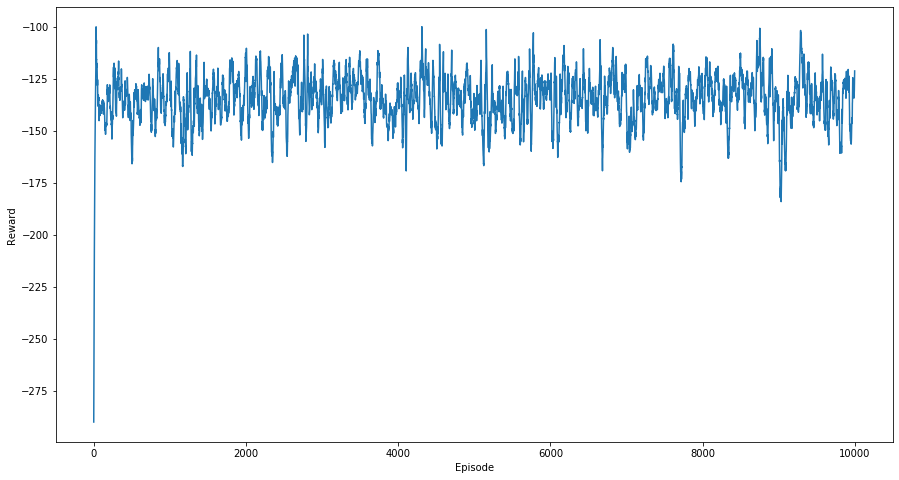

In [180]:
from scipy.signal import savgol_filter # to smooth the rewards

plt.figure(figsize = (15,8))
plt.plot(np.arange(e+1),savgol_filter(episode_rewards, 51, 3))
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

In [181]:
# close the environment 
env.close()